# Gibbs sampler with the Bivariate normal disttibution

This is a short post on recreating the Gibbs sampler example from [p277 of Gelman's
Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/)

## Alternating conditional sampling
To remind my future self of how this works I am going to recreate the details of 
the Gibbs sampler for a two dimensional problem. Suppose the parameter vector
$\theta$ has two components $\theta= [\theta_1, \theta_2]$, then each iteration
of the Gibbs sampler cycles through each component and draws a new value conditional
on all the others. There are thus 2 steps for each iteration. We consider the example
of the bivariate normal distribution with unknown mean $\theta$, but known 
covariance matrix 

$$\left(\begin{array}{cc}1 & \rho \\ \rho & 1 \end{array}\right).$$

If one observation $y=[y_1, y2]$ is made and a uniform prior on $\theta$
is used, the posterior is given by 

$$ \left(\begin{array}{c} \theta_1 \\ \theta_2 \end{array}\right) \biggr\rvert y
 \sim N\left(\left(\begin{array}{c} y_1 \\ y_2 \end{array}\right), 
        \left(\begin{array}{cc}1 & \rho \\ \rho & 1 \end{array}\right)\right)
$$

In order to illustrate the use of the Gibbs sampler we need the conditional 
posterior distributions, which from the properties of multivariate normal
distributions are given by 
$$ \theta_1 | \theta_2, y \sim N\left(y_1 + \rho(\theta_2 - y_2), 1-\rho^{2}\right) $$
$$ \theta_1 | \theta_1, y \sim N\left(y_2 + \rho(\theta_1 - y_1), 1-\rho^{2}\right) $$

The Gibbs sampler proceeds by alternately sampling from these two normal 
distributions. This is now coded in simple Python deliberately making the
steps obvious. 

In [123]:
from numpy.random import normal      
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.labelsize'] = 22

In [90]:
def GibbsSampler(theta0, y, k, rho):
    """ Simple implementation of the Gibbs sampler for a bivariate normal
        distribution. """
    
    theta = [theta0]
    for i in range(k):
        theta2 = theta[-1][1] # theta2 from previous iteration
        theta1 = normal(y[0] + rho*(theta2 - y[1]), 1-rho**2)
        theta.append([theta1, theta2])
        theta2 = normal(y[1] + rho*(theta1 - y[0]), 1-rho**2)
        theta.append([theta1, theta2])
        
    return np.array(theta)
        
# Data as given by Gelman et al. 
y = [0, 0]
rho = 0.8
k = 500

# Four chains starting from four points of a square
theta0_list = [[-2.5, -2.5], [2.5, -2.5], [-2.5, 2.5], [2.5, 2.5]]
data = []
for theta0 in theta0_list:
    data.append(GibbsSampler(theta0, y, k, rho))

data = np.array(data)
print np.array(data).shape

(4, 1001, 2)


Here `data` is a $4 \times 2k+1 \times d$ `numpy` `array`. The first axis gives the four chains (started from four different initial conditions, the second gives the iteration number (of length $2k+1$ for each chain because we are
saving the data after each update and we added the initial data, the final axis is the number of dimensions (in this case 2). 


### Recreate figure 11.2 a

First lets just look at the first few steps of all four chains. What we are plotting
here is the location, in thet $\theta$ parameter space, of each chain. 

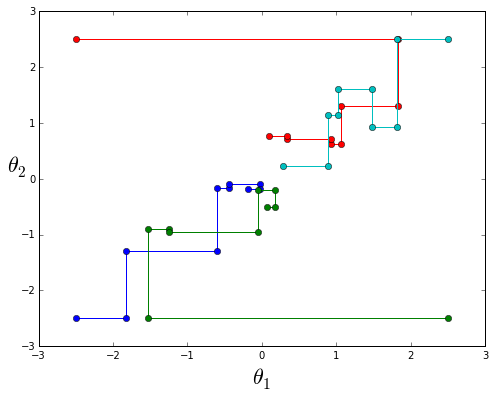

In [91]:
nsteps = 10
for i in range(4):
    plt.plot(data[i, 0:nsteps, 0], data[i, 0:nsteps, 1], "o-")
    
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$", rotation="horizontal")

plt.show()

### Recreating figure 11.2 b

Now we increase the number of steps to the full range

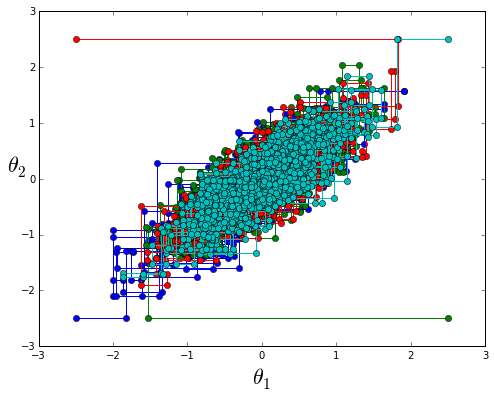

In [92]:
for i in range(4):
    plt.plot(data[i, 0:, 0], data[i, 0:, 1], "o-")
    
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$", rotation="horizontal")

plt.show()

### Removing the repeated data

In the example so far we purposefully left in data from the updates *during*
each iteration. Before trying to do any analysis this should be removed.

In [93]:
data_reduced = data[:, ::2, :]
print data_reduced.shape

(4, 501, 2)


### Illustration of the burn in period

The step which is not so obvious in Gelman BDA is why they remove the
first half of data - the so-called burn-in period. To illustrate we
plot the values of $\theta_i$ against the iteration number. This is done
for all four chains.

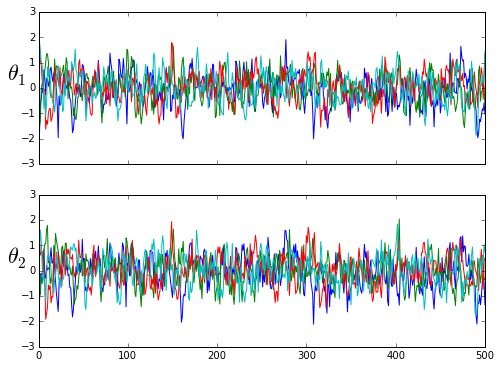

In [94]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

for j in range(4):
    ax1.plot(range(k+1), data_reduced[j, :, 0])
    ax2.plot(range(k+1), data_reduced[j, :, 1])

ax1.set_ylabel(r"$\theta_1$", rotation="horizontal")
ax2.set_ylabel(r"$\theta_2$", rotation="horizontal")
plt.show()

The takeaway here is that at least for the first 50 iterations
the chains display same memory of their initial position. After
this the appear to have 'converged' to an approximation of
the posterior distribution. For this reason Gelman discards
the first half of data.

### Plotting the marginal and joint posterior

11.2 c is the joint posterior distribution $p(\theta_1, \theta_2| y$. 
We can now plot this along with the marginal distributions for each
individual parameter in a so-called triangle plot.

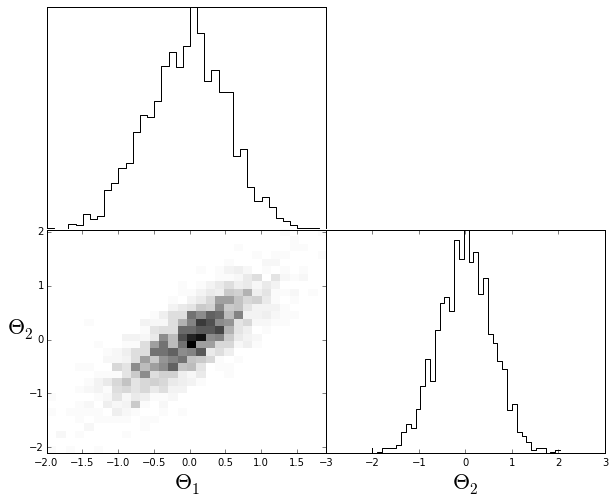

In [131]:
# Generate figure and axes
fig = plt.figure(figsize=(10, 8))
ndim = 2
ax1 = plt.subplot2grid((ndim, ndim), (0, 0))
ax2 = plt.subplot2grid((ndim, ndim), (1, 0))
ax3 = plt.subplot2grid((ndim, ndim), (1, 1))

# Remove labels
ax1.set_xticks([])
ax1.set_yticks([])
ax3.set_yticks([])

# Get the final data
burnin=50
data_burnt = data_reduced[:, burnin:, :] # Burn first 100 points
data_final = data_burnt.reshape(4 * (k-burnin + 1), 2) # Flatten chain data

# Plot the marginal distribution for theta1
hist, bin_edges = np.histogram(data_final[:, 0], bins=40, normed=True)
bin_mids = bin_edges[:-1] + np.diff(bin_edges)
ax1.step(bin_mids, hist, color="k")

# Plot the joint distribution 
ax2.hist2d(data_final[:, 0], data_final[:, 1], bins=30,  cmap=plt.cm.Greys)

# Plot the marginal distribution for theta1
hist, bin_edges = np.histogram(data_final[:, 1], bins=40, normed=True)
bin_mids = bin_edges[:-1] + np.diff(bin_edges)
ax3.step(bin_mids, hist, color="k")


ax2.set_xlabel(r"$\Theta_1$")
ax2.set_ylabel(r"$\Theta_2$", rotation="horizontal", labelpad=10)
ax3.set_xlabel(r"$\Theta_2$")

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

The lower left panel is the joint probability distribution as approximated
by the Gibbs sampler (11.2 c). The other two plots show the marginal 
distributions for each of the parameters. 

As a note a nice `python` package written by [Daniel Foreman-Mackay](https://github.com/dfm/triangle.py) exist to automate this type of triangular plot.